In [0]:
from time import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pdb
import cv2
import warnings


from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import DictionaryLearning
from google.colab import drive
from google.colab import files


In [0]:
%matplotlib inline

In [13]:
# Mount GoogleDrive and get images
warnings.filterwarnings('ignore')
drive.mount('/content/drive')
uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving andy.jpg to andy.jpg


In [0]:
# General algorithm configuration

n_comp = 50
n_iter = 5000
coeff = 2
alpha = 0.1
noise_amount = 0.15
path = 'andy.jpg'


In [0]:
# Algorithm of vocabulary batch update

def ksvd(noisy_data):
    print('Updating dictionary')
    t = time()
    
    upd_dictionary = MiniBatchDictionaryLearning(n_components=n_comp, 
                                                 alpha = alpha,
                                                 n_iter = n_iter)
    
    V = upd_dictionary.fit(noisy_data).components_
        
    dt = time() - t
    print('done in %.2fs.' % dt)
    
    return V, upd_dictionary
    

In [0]:
# Applies random noise on input image and extracts reference patches

def noisy_patches(image, dict_learning = False, channel = None):
    image = image / 255.
    
    if dict_learning:
        # Downsampling
        image = image[::2, ::2] + image[1::2, ::2] + image[::2, 1::2] + image[1::2, 1::2]
        image /= 4.0
    
    print('Distorting original image..')
    
    distorted_img = image.copy()
    
    if channel:
        height, width, channel = image.shape
        distorted_img += noise_amount * np.random.randn(height, width, channel)
    else:
        height, width = image.shape
        distorted_img += noise_amount * np.random.randn(height, width)
    
    noisy_name = 'noisy_' + path
    
    show_image(distorted_img, 'Distorted image')
     
    print('Extracting reference patches..')
    
    t = time()
    
    patch_size = (7,7)
    data = extract_patches_2d(distorted_img, patch_size)
    data = data.reshape(data.shape[0], -1)
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    
    data -= mean # Zero mean
    data /= std 
    
    dt = time() - t
    print('done in %.2fs.' % dt)
    
    return(data, mean, std)
    

In [0]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

In [0]:
def show_image(image, title):
  fix,ax = plt.subplots()
  ax.grid(False)
  plt.title(title)
  ax.imshow(image[...,::-1])

In [0]:
def start():
    image = cv2.imread(path)
    
    channel = None # Initially we don't know if image is RGB or grayscale
    
    if len(image.shape) > 2:
        channel = image.shape[2]
        
    data, _, _ = noisy_patches(image, dict_learning=True, channel=channel)
    dict_final, dico = ksvd(data)
    n0_data, mean, std= noisy_patches(image,channel=channel)
    
    # Transform dictionary
    dico.set_params(transform_algorithm='omp',transform_n_nonzero_coefs = coeff)
    
    code = dico.transform(n0_data)
    
    # Apply noisy patches
    
    patches = np.dot(code,dict_final)
    patches *= std
    patches += mean
    patches = (patches.reshape(n0_data.shape[0], 7, 7, channel))
    
    # Reconstructing
    
    print('Reconstructing original image...')
    
    reconstruction = reconstruct_from_patches_2d(patches, (image.shape[0], image.shape[1], channel))
    reconstruction*=255
    
    # Calculate the difference and square error
    
    difference = image - reconstruction
    error = np.sqrt(np.sum(difference ** 2))
    
    psnr_value = psnr(image, reconstruction)
    print('PSNR value %.2f' %psnr_value)
    
    print('Difference (norm: %.2f)' %error)
    
    print('Finished image reconstruction...')
    
    # Save images
    
    original_name = 'original_' + path
    reconstructed_name = 'reconstructed_' + path
    
    show_image(image, 'Original image')
    
    show_image(reconstruction.astype('uint8'), 'Reconstructed image')
    
   
    
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Distorting original image..
Extracting reference patches..
done in 0.66s.
Updating dictionary
done in 158.79s.
Distorting original image..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracting reference patches..
done in 2.46s.
Reconstructing original image...
PSNR value 28.70
Difference (norm: 15572.72)
Finished image reconstruction...


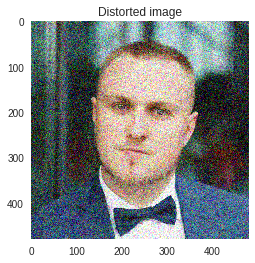

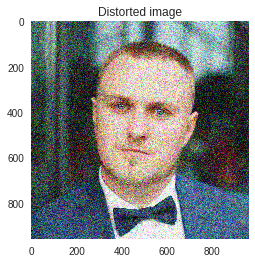

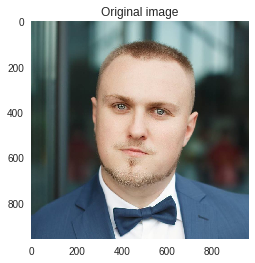

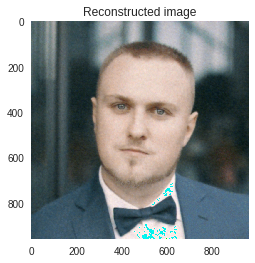

In [15]:
start() # Start the denoising